
=== LORO: train [6, 7, 8], test 5 ===
Epoch [1/101] test loss: 0.34849, training loss: -1.00000
Epoch [51/101] test loss: 0.02491, training loss: 0.02182
Epoch [101/101] test loss: 0.01498, training loss: 0.01046
Running sequential inference on 847 windows...
Skipping K-NN inference (db_kmeans is None)

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.934 ± 0.770 m
K-NN evaluation skipped (db_kmeans was None)
CNN samples: 847

=== LORO: train [5, 7, 8], test 6 ===
Epoch [1/101] test loss: 0.30854, training loss: -1.00000
Epoch [51/101] test loss: 0.01936, training loss: 0.01396
Epoch [101/101] test loss: 0.00778, training loss: 0.00597
Running sequential inference on 1829 windows...
Skipping K-NN inference (db_kmeans is None)

SEQUENTIAL INFERENCE PERFORMANCE SUMMARY
CNN Error: 0.938 ± 0.693 m
K-NN evaluation skipped (db_kmeans was None)
CNN samples: 1829

=== LORO: train [5, 6, 8], test 7 ===
Epoch [1/101] test loss: 0.34860, training loss: -1.00000
Epoch [51/101] test loss: 0.0

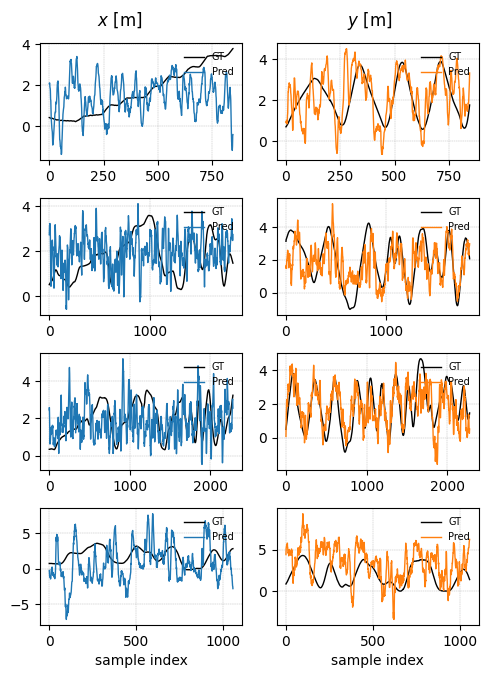

In [1]:
# --------------------------------------------------
#  leave-one-recording-out evaluation (R2) — final fig
# --------------------------------------------------
from auxiliary import (loadData_staticTargetAddrMatch, prepare_data_loaders,
                       create_sequential_inference_loader, apply_normalization,
                       run_sequential_inference)
from algorithms import (RssPosAlgo_NeuralNet_CNNv1,
                        RssPosAlgo_NeuralNet_supervisedTrainingLoop)
import numpy as np, torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

target_addresses = ["d8:47:32:eb:6c:38",
                    "50:c7:bf:19:e6:4d",
                    "18:28:61:3d:94:7a"]

experiments   = [5, 6, 7, 8]
exp_labels    = {5: 'Exp-5', 6: 'Exp-6', 7: 'Exp-7', 8: 'Exp-8'}

kernel_sizes  = [13, 11, 9, 7]
channels      = [8, 16, 8, 2]
window_size   = sum(k-1 for k in kernel_sizes) + 1
batch_size    = 64
epochs        = 101
lr            = 2e-3

norm_params = {
    'rss_mean': np.asarray([-65.0, -65.0, -65.0]),
    'rss_std':  np.asarray([20.0, 20.0, 20.0]),
    'loc_mean': np.asarray([2.0, 2.0]),
    'loc_std':  np.asarray([2.0, 2.0])
}

def load_concat(ids):
    rss, loc = [], []
    for e in ids:
        p = f"../experiments/exp00{e}_20250526_sna_kadirerdem/data-tshark/data.json"
        r, l = loadData_staticTargetAddrMatch(p, second_hold=5, shuffle=False,
                             target_addresses=target_addresses, snap250ms=False)
        rss.append(r); loc.append(l)
    return np.vstack(rss), np.vstack(loc)

# fig setup
fig, axes = plt.subplots(len(experiments), 2, figsize=(5, 1.7*len(experiments)),
                         sharex=False)
axes = axes if len(experiments) > 1 else axes.reshape(1,2)

for r, test_exp in enumerate(experiments):
    train_exps = [e for e in experiments if e != test_exp]
    print(f"\n=== LORO: train {train_exps}, test {test_exp} ===")

    # ---------- train ----------
    rss_t, loc_t   = load_concat(train_exps)
    rss_t_n, loc_t_n, _ = apply_normalization(rss_t, loc_t, norm_params)

    tr_loader, val_loader, *_ = prepare_data_loaders(
        rss_t_n, loc_t_n, batch_size=batch_size, window_size=window_size,
        train_test_split=0.85, cnn_data=True, cnn_kernel_sizes=kernel_sizes)

    net = RssPosAlgo_NeuralNet_CNNv1(channels, kernel_sizes).cuda()
    net.device = "cuda"
    net = RssPosAlgo_NeuralNet_supervisedTrainingLoop(
            tr_loader, val_loader, net,
            nn.MSELoss(), optim.Adam(net.parameters(), lr=lr),
            epochs=epochs, testfreq=50)

    # ---------- test ----------
    rss_s, loc_s = load_concat([test_exp])
    rss_s_n, loc_s_n, _ = apply_normalization(rss_s, loc_s, norm_params)
    seq_loader, xts, yts = create_sequential_inference_loader(
        rss_s_n, loc_s_n, window_size, cnn_data=True,
        cnn_kernel_sizes=kernel_sizes)

    res  = run_sequential_inference(seq_loader, net, xts, yts, norm_params,
                                    RssPosAlgo_NearestNeighbour=None,
                                    RssPosAlgo_NearestNeighbour_Interpolation=None,
                                    db_kmeans=None)
    pred = res['cnn_predictions'].squeeze()
    gt   = res['cnn_ground_truths'].squeeze()
    t    = np.arange(len(pred))

    ax_x, ax_y = axes[r]

    # left column (x)
    ax_x.plot(t, gt[:,0],  'k-',        lw=1, label='GT')
    ax_x.plot(t, pred[:,0],'tab:blue',  lw=1, label='Pred')
    ax_x.grid(ls='--', lw=0.3)
    #ax_x.set_yticks([])
    #ax_x.set_ylabel(exp_labels[test_exp], rotation=0,
    #                labelpad=38, ha='center', va='center', fontsize=10)
    ax_x.legend(frameon=False, fontsize=7, loc='upper right')

    # right column (y)
    ax_y.plot(t, gt[:,1],  'k-',         lw=1, label='GT')
    ax_y.plot(t, pred[:,1],'tab:orange', lw=1, label='Pred')
    ax_y.grid(ls='--', lw=0.3)
    #ax_y.set_yticks([])
    ax_y.legend(frameon=False, fontsize=7, loc='upper right')

    if r == len(experiments)-1:          # bottom row → x-axis label
        ax_x.set_xlabel('sample index')
        ax_y.set_xlabel('sample index')

# column titles
fig.text(0.25, 0.99, '$x$ [m]', ha='center', va='top', fontsize=12)
fig.text(0.75, 0.99, '$y$ [m]', ha='center', va='top', fontsize=12)

fig.tight_layout(rect=[0,0,1,0.97])
fig.savefig("pub2.png", dpi=300)
plt.show()


In [2]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import pearsonr
from auxiliary import loadData_staticTargetAddrMatch

for exp_id in [5,6,7,8]:
    # ------------ user parameters -----------------
    #exp_id = 7                           # recording to analyse
    target_addresses = ["d8:47:32:eb:6c:38",
                        "50:c7:bf:19:e6:4d",
                        "18:28:61:3d:94:7a"]
    # ----------------------------------------------
    
    json_path = f"../experiments/exp00{exp_id}_20250526_sna_kadirerdem/data-tshark/data.json"
    rss, loc  = loadData_staticTargetAddrMatch(json_path, second_hold=5,
                       shuffle=False, target_addresses=target_addresses,
                       snap250ms=False)
    
    # successive differences
    d_r  = np.linalg.norm(np.diff(rss, axis=0), axis=1)        # (N-1,)
    d_x  = np.abs(np.diff(loc[:,0]))
    d_y  = np.abs(np.diff(loc[:,1]))
    
    rho_x, p_x = pearsonr(d_x, d_r)
    rho_y, p_y = pearsonr(d_y, d_r)
    
    print(f"Exp {exp_id}:")
    print(f"corr(|Δx|, ΔRSS) = {rho_x:.3f}  (p={p_x:.2g})")
    print(f"corr(|Δy|, ΔRSS) = {rho_y:.3f}  (p={p_y:.2g})")
    print("")

Exp 5:
corr(|Δx|, ΔRSS) = 0.086  (p=0.011)
corr(|Δy|, ΔRSS) = 0.027  (p=0.42)

Exp 6:
corr(|Δx|, ΔRSS) = 0.116  (p=5.5e-07)
corr(|Δy|, ΔRSS) = 0.048  (p=0.038)

Exp 7:
corr(|Δx|, ΔRSS) = 0.055  (p=0.0081)
corr(|Δy|, ΔRSS) = 0.024  (p=0.26)

Exp 8:
corr(|Δx|, ΔRSS) = -0.006  (p=0.85)
corr(|Δy|, ΔRSS) = 0.003  (p=0.93)



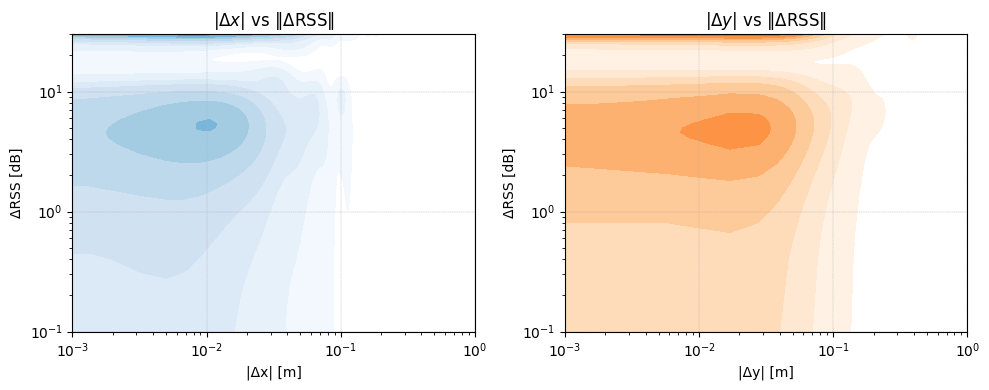

In [3]:
# ----------- visual aid: joint KDE --------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.kdeplot(x=d_x, y=d_r, cmap="Blues", fill=True, bw_adjust=.5)
plt.title(r'$|\Delta x|$ vs $\|\Delta\mathrm{RSS}\|$')
plt.xlabel('|Δx| [m]'); plt.ylabel('ΔRSS [dB]'); plt.grid(ls='--', lw=0.3)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1.0)      # 1 mm  to 1 m
ax.set_ylim(1e-1, 30)       # 0.1 dB to 30 dB

plt.subplot(1,2,2)
sns.kdeplot(x=d_y, y=d_r, cmap="Oranges", fill=True, bw_adjust=.5)
plt.title(r'$|\Delta y|$ vs $\|\Delta\mathrm{RSS}\|$')
plt.xlabel('|Δy| [m]'); plt.ylabel('ΔRSS [dB]'); plt.grid(ls='--', lw=0.3)

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-3, 1.0)      # 1 mm  to 1 m
ax.set_ylim(1e-1, 30)       # 0.1 dB to 30 dB

plt.tight_layout()
plt.show()

